# 0. Importing the libs and read the data

In [12]:
# Core Libraries
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import shutil
import random
import math
import json
import os

# ML Libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from datetime import datetime
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import torch

# 1. EDA & Data preparation

### Loading a sample of each category

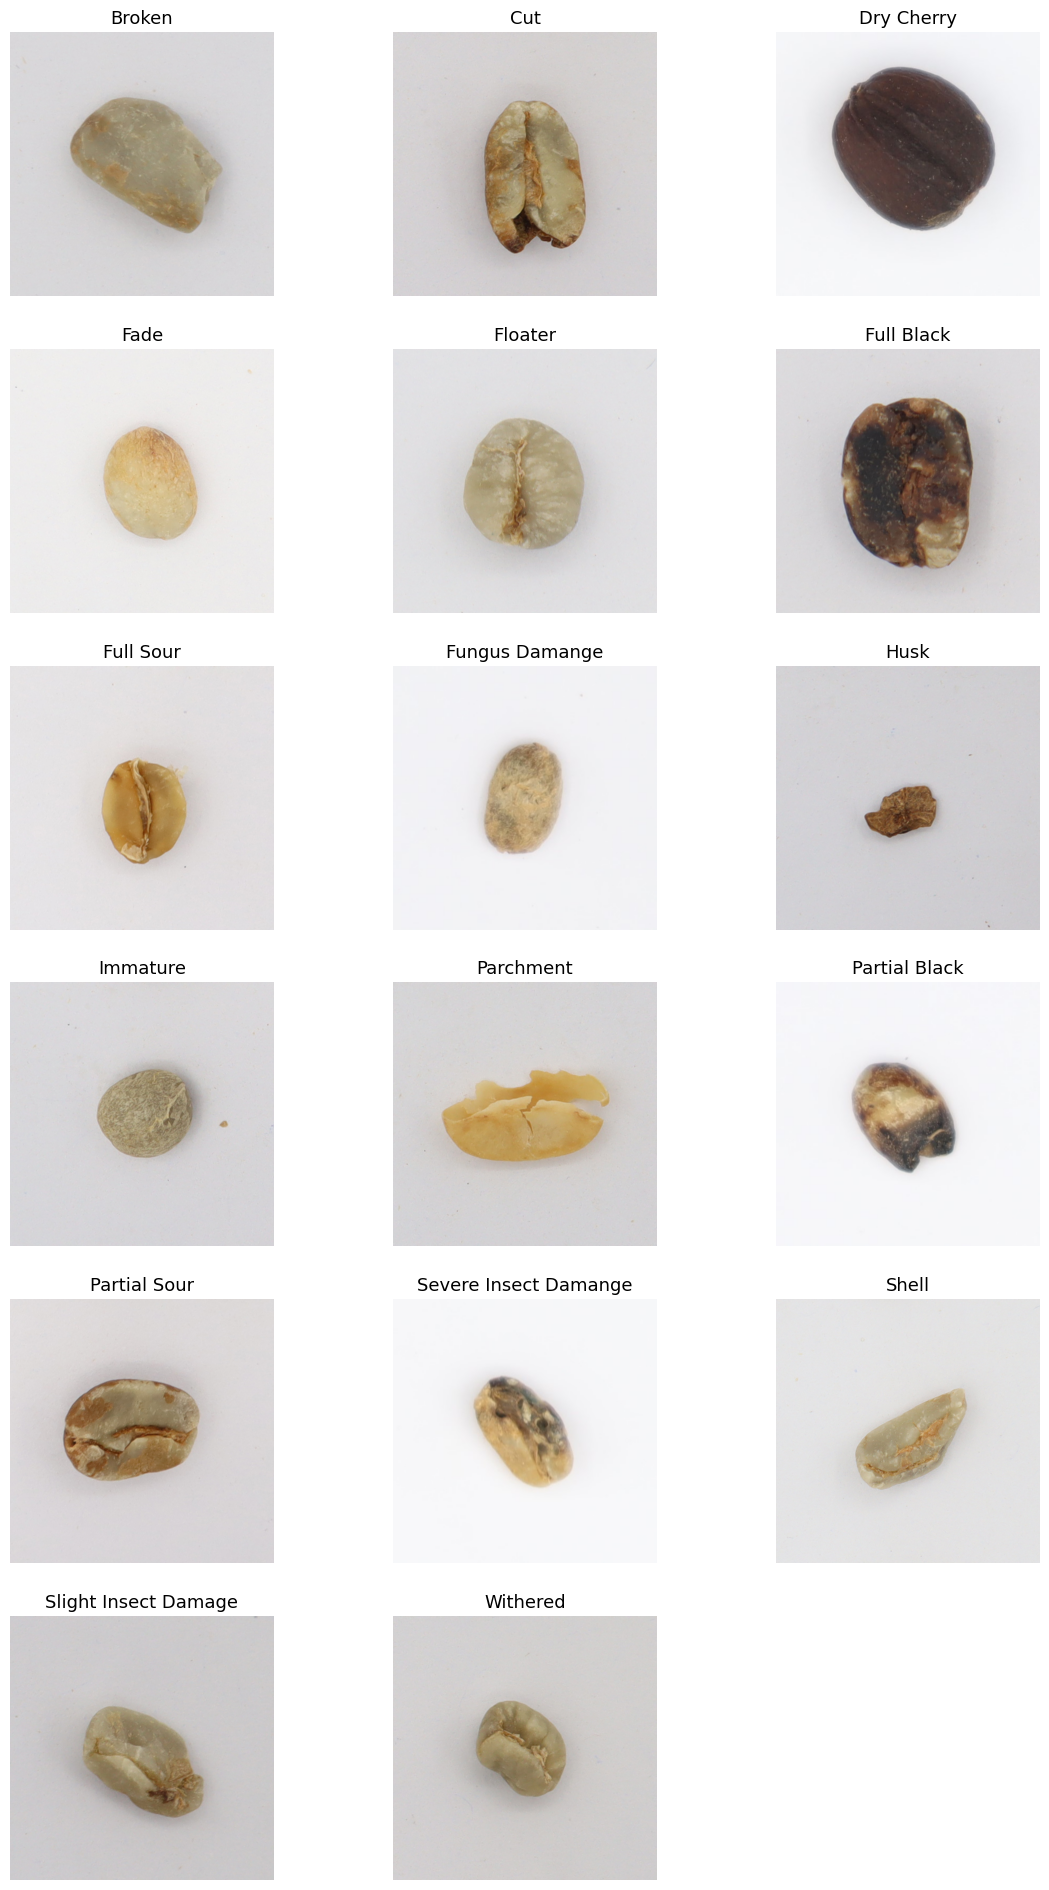

In [2]:
RAW_DIR = "data/raw"
classes = sorted([
    d for d in os.listdir(RAW_DIR)
    if os.path.isdir(os.path.join(RAW_DIR, d))
])

n_cols = 3
n_rows = math.ceil(len(classes) / n_cols)

plt.figure(figsize=(14, 4 * n_rows))

for i, defect in enumerate(classes):
    defect_path = os.path.join(RAW_DIR, defect)

    images = [
        img for img in os.listdir(defect_path)
        if img.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    if len(images) == 0:
        continue

    img_name = random.choice(images)
    img_path = os.path.join(defect_path, img_name)

    img = Image.open(img_path)

    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.title(defect, fontsize=13, pad=6)
    plt.axis("off")

plt.show()

### Count number of files per defect class

In [3]:
data = []
for defect in sorted(os.listdir(RAW_DIR)):
    defect_path = os.path.join(RAW_DIR, defect)

    if not os.path.isdir(defect_path):
        continue

    images = [
        f for f in os.listdir(defect_path)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    data.append({
        "defect": defect,
        "num_images": len(images)
    })

df_counts = pd.DataFrame(data).sort_values("num_images", ascending=False).reset_index(drop=True)

df_counts

,defect,num_images
0,Immature,78
1,Full Sour,75
2,Fungus Damange,75
3,Cut,66
4,Partial Black,65
5,Broken,62
6,Shell,57
7,Severe Insect Damange,57
8,Slight Insect Damage,55
9,Parchment,54


### Class distribution

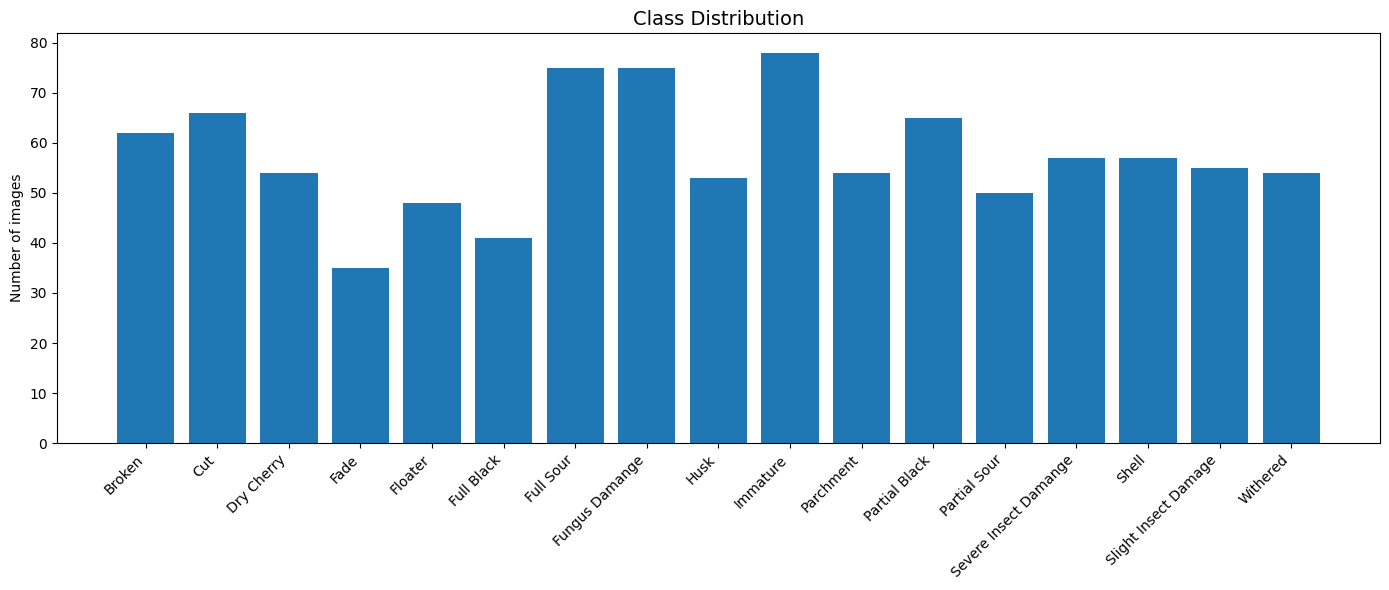

In [4]:
class_counts = {}
for defect in sorted(os.listdir(RAW_DIR)):
    defect_path = os.path.join(RAW_DIR, defect)

    if not os.path.isdir(defect_path):
        continue

    images = [
        img for img in os.listdir(defect_path)
        if img.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    class_counts[defect] = len(images)

plt.figure(figsize=(14, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution", fontsize=14)
plt.ylabel("Number of images")
plt.tight_layout()
plt.show()

### The percentage breakdown of each defect class

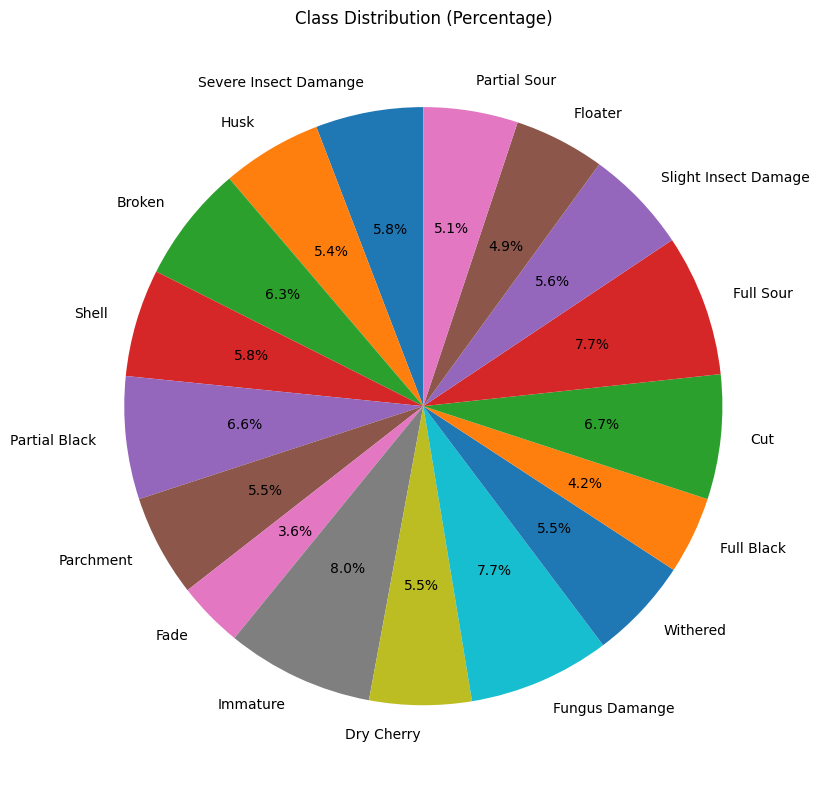

In [5]:
class_counts = {defect: len([f for f in os.listdir(os.path.join(RAW_DIR, defect)) if f.lower().endswith((".png", ".jpg", ".jpeg"))]) for defect in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, defect))}
plt.figure(figsize=(12, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct="%1.1f%%", startangle=90)
plt.title("Class Distribution (Percentage)")
plt.tight_layout()
plt.show()

### Size and format distribution

/var/folders/cf/yvx1ty9x60zg9rmfrmvm7pyc0000gn/T/ipykernel_43930/572266237.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([size_stats[d] for d in sorted(size_stats.keys())], labels=sorted(size_stats.keys()))


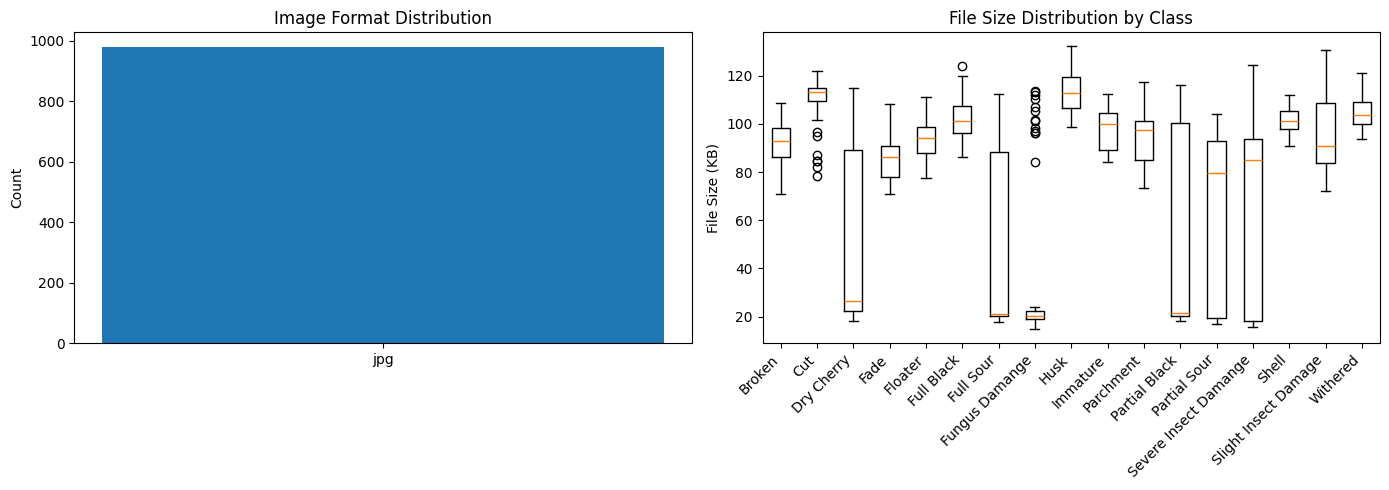

In [6]:
file_stats = defaultdict(int)
size_stats = defaultdict(list)

for defect in os.listdir(RAW_DIR):
    defect_path = os.path.join(RAW_DIR, defect)
    for img in os.listdir(defect_path):
        ext = img.split('.')[-1].lower()
        file_stats[ext] += 1
        img_path = os.path.join(defect_path, img)
        size_stats[defect].append(os.path.getsize(img_path) / 1024)  # KB

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.bar(file_stats.keys(), file_stats.values())
plt.title("Image Format Distribution")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.boxplot([size_stats[d] for d in sorted(size_stats.keys())], labels=sorted(size_stats.keys()))
plt.xticks(rotation=45, ha="right")
plt.title("File Size Distribution by Class")
plt.ylabel("File Size (KB)")
plt.tight_layout()
plt.show()

### The ratio between most/least common classes

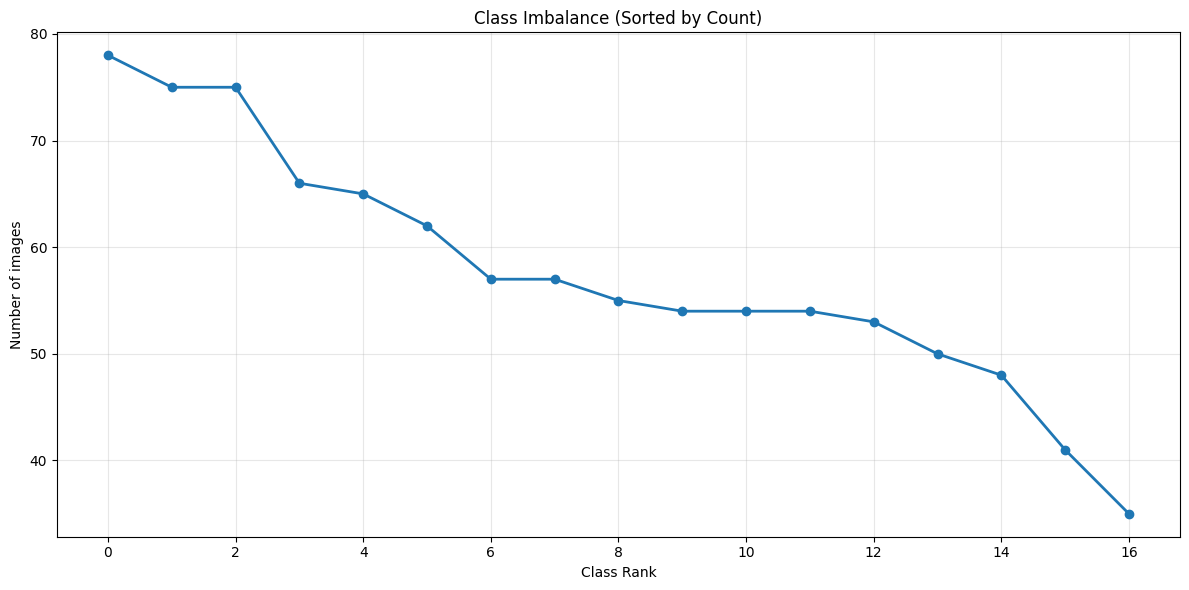

In [7]:
sorted_counts = sorted(class_counts.values(), reverse=True)
plt.figure(figsize=(12, 6))
plt.plot(sorted_counts, marker='o', linewidth=2)
plt.title("Class Imbalance (Sorted by Count)")
plt.xlabel("Class Rank")
plt.ylabel("Number of images")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Imbalanced classes analysis

In [8]:
max_count = max(class_counts.values())
min_count = min(class_counts.values())

imbalance_ratio = max_count / min_count if min_count > 0 else float("inf")

print("Class distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

print(f"\nImbalance ratio (max / min): {imbalance_ratio:.2f}")

# optional warning
if imbalance_ratio > 5:
    print("\n⚠️ Dataset is highly imbalanced.")
elif imbalance_ratio > 2:
    print("\n⚠️ Dataset is moderately imbalanced.")
else:
    print("\n✅ Dataset is relatively balanced.")

Class distribution:
Severe Insect Damange: 57
Husk: 53
Broken: 62
Shell: 57
Partial Black: 65
Parchment: 54
Fade: 35
Immature: 78
Dry Cherry: 54
Fungus Damange: 75
Withered: 54
Full Black: 41
Cut: 66
Full Sour: 75
Slight Insect Damage: 55
Floater: 48
Partial Sour: 50

Imbalance ratio (max / min): 2.23

⚠️ Dataset is moderately imbalanced.


### Train / Val / Test Split
 - reads from data/raw
 - creates data/processed
 - splits 60 / 20 / 20 per class
 - copies images

In [9]:
RAW_DIR = Path("data/raw")
PROCESSED_DIR = Path("data/processed")

TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

SEED = 42
random.seed(SEED)

# Create base folders
for split in ["train", "val", "test"]:
    (PROCESSED_DIR / split).mkdir(parents=True, exist_ok=True)

# Split per class
for defect in os.listdir(RAW_DIR):
    defect_path = RAW_DIR / defect

    if not defect_path.is_dir():
        continue

    images = [
        f for f in os.listdir(defect_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * TRAIN_RATIO)
    n_val = int(n_total * VAL_RATIO)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    # create class folders
    for split in ["train", "val", "test"]:
        (PROCESSED_DIR / split / defect).mkdir(parents=True, exist_ok=True)

    # copy files
    for img in train_imgs:
        shutil.copy(
            defect_path / img,
            PROCESSED_DIR / "train" / defect / img
        )

    for img in val_imgs:
        shutil.copy(
            defect_path / img,
            PROCESSED_DIR / "val" / defect / img
        )

    for img in test_imgs:
        shutil.copy(
            defect_path / img,
            PROCESSED_DIR / "test" / defect / img
        )

    print(
        f"{defect}: "
        f"train={len(train_imgs)}, "
        f"val={len(val_imgs)}, "
        f"test={len(test_imgs)}"
    )

print("\n✅ Dataset successfully split into train / val / test")

Severe Insect Damange: train=34, val=11, test=12
Husk: train=31, val=10, test=12
Broken: train=37, val=12, test=13
Shell: train=34, val=11, test=12
Partial Black: train=39, val=13, test=13
Parchment: train=32, val=10, test=12
Fade: train=21, val=7, test=7
Immature: train=46, val=15, test=17
Dry Cherry: train=32, val=10, test=12
Fungus Damange: train=45, val=15, test=15
Withered: train=32, val=10, test=12
Full Black: train=24, val=8, test=9
Cut: train=39, val=13, test=14
Full Sour: train=45, val=15, test=15
Slight Insect Damage: train=33, val=11, test=11
Floater: train=28, val=9, test=11
Partial Sour: train=30, val=10, test=10

✅ Dataset successfully split into train / val / test


### Count images per defect (train / val / test)

In [10]:
import os
import pandas as pd

BASE_DIR = "data/processed"
SPLITS = ["train", "val", "test"]

data = {}

for split in SPLITS:
    split_dir = os.path.join(BASE_DIR, split)

    for defect in os.listdir(split_dir):
        defect_path = os.path.join(split_dir, defect)

        if not os.path.isdir(defect_path):
            continue

        images = [
            f for f in os.listdir(defect_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

        if defect not in data:
            data[defect] = {}

        data[defect][split] = len(images)

# build dataframe
df_counts = (
    pd.DataFrame.from_dict(data, orient="index")
    .fillna(0)
    .astype(int)
)

df_counts["total"] = df_counts["train"] + df_counts["val"] + df_counts["test"]

df_counts = df_counts.sort_values("total", ascending=False).reset_index()
df_counts.rename(columns={"index": "defect"}, inplace=True)

df_counts

,defect,train,val,test,total
0,Immature,46,15,17,78
1,Full Sour,45,15,15,75
2,Fungus Damange,45,15,15,75
3,Cut,39,13,14,66
4,Partial Black,39,13,13,65
5,Broken,37,12,13,62
6,Severe Insect Damange,34,11,12,57
7,Shell,34,11,12,57
8,Slight Insect Damage,33,11,11,55
9,Withered,32,10,12,54


### Class distribution for train / val / test

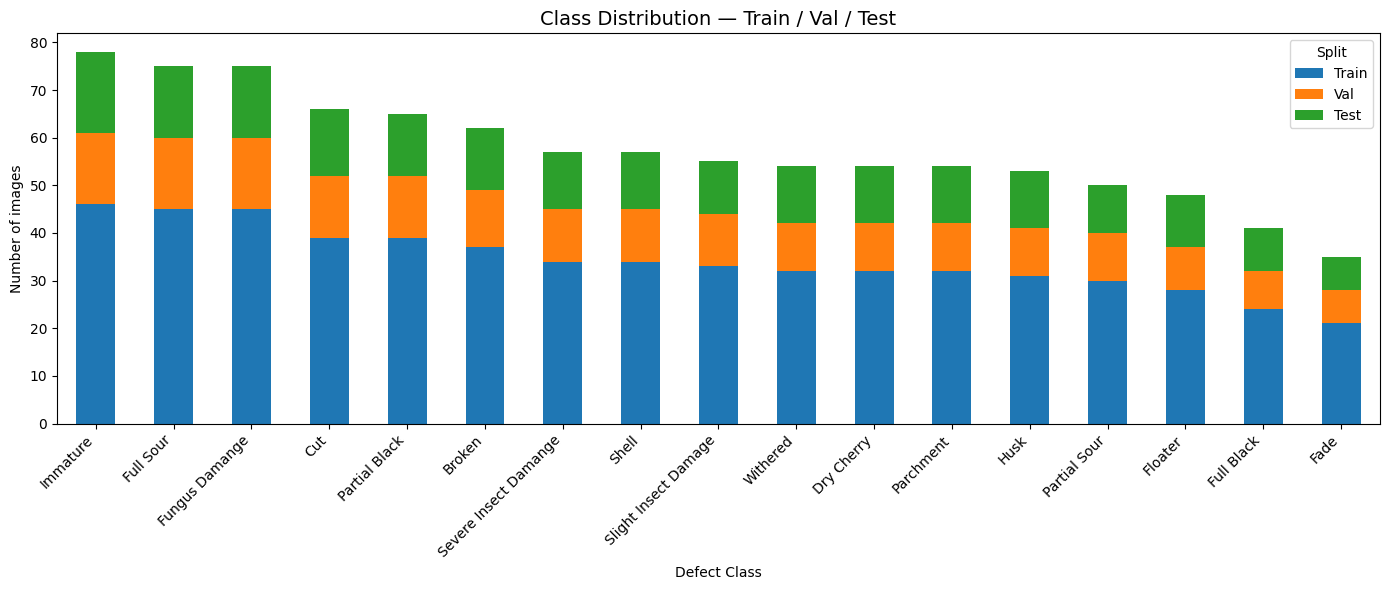

In [11]:
df_plot = df_counts[["defect", "train", "val", "test"]].set_index("defect")

# Create stacked bar chart
plt.figure(figsize=(14, 6))
df_plot.plot(kind="bar", stacked=True, ax=plt.gca(), 
             color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title("Class Distribution — Train / Val / Test", fontsize=14)
plt.xlabel("Defect Class")
plt.ylabel("Number of images")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Split", labels=["Train", "Val", "Test"])
plt.tight_layout()
plt.show()

# 2. Transfer Learning & Model Training

### Project Overview
- **Goal**: Detect and classify 17 different types of defects in Arabica green coffee beans
- **Approach**: Transfer learning with pretrained models (ResNet50, EfficientNet, MobileNet, ConvNeXt)
- **Dataset**: 962 images total (train: 60%, val: 20%, test: 20%)
- **Output**: Trained models with performance comparison

### Check GPU availability

In [ ]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Create models folder

In [18]:
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)
print(f"Models directory created: {models_dir}")

Models directory created: models


### Data Loading and Preprocessing

In [15]:
class CoffeeDefectDataset(Dataset):
    """A custom dataset class for loading coffee defect images."""

    def __init__(self, image_dir, transform=None):
        """
            image_dir: Path to the directory containing images organized in class subdirectories.
            transform: Optional torchvision transforms to apply to the images.
        """
        self.image_paths = []
        self.labels = []
        self.classes = sorted([d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(image_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(class_idx)
        
        self.transform = transform
    
    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """Returns the image and label at the specified index."""
        from PIL import Image
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

### Define data augmentations and transformations

In [16]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

### Load datasets with transformations

In [17]:
train_dataset = CoffeeDefectDataset("data/processed/train", transform=train_transform)
val_dataset = CoffeeDefectDataset("data/processed/val", transform=val_test_transform)
test_dataset = CoffeeDefectDataset("data/processed/test", transform=val_test_transform)

print(f"Datasets created:")
print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")
print(f"Number of classes: {len(train_dataset.classes)}")

Datasets created:
Train: 582 images
Val: 190 images
Test: 207 images
Number of classes: 17


### Model Initialization and Training Framework

In [19]:
def get_pretrained_model(model_name, num_classes=17, freeze_backbone=True):
    """Load pretrained model and modify for coffee defect classification"""
    
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    
    elif model_name == "efficientnet_b2":
        model = models.efficientnet_b2(pretrained=True)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    
    elif model_name == "mobilenet_v3":
        model = models.mobilenet_v3_large(pretrained=True)
        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_features, num_classes)
    
    elif model_name == "convnext_tiny":
        model = models.convnext_tiny(pretrained=True)
        num_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(num_features, num_classes)
    
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    # Freeze backbone weights if specified
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        
        # Unfreeze classifier layer
        if model_name == "resnet50":
            for param in model.fc.parameters():
                param.requires_grad = True
        elif model_name.startswith("efficientnet"):
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif model_name == "mobilenet_v3":
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif model_name == "convnext_tiny":
            for param in model.classifier.parameters():
                param.requires_grad = True
    
    return model

### Test model loading

In [20]:
test_model = get_pretrained_model("resnet50")
print(f"Model loading test successful")
print(f"ResNet50 loaded and adapted for 17 classes")

/Users/alexandru.huc/Downloads/Development/GitHub/coffee-quality-inspection-vision/coffee_v/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexandru.huc/Downloads/Development/GitHub/coffee-quality-inspection-vision/coffee_v/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/alexandru.huc/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100.0%


Model loading test successful
ResNet50 loaded and adapted for 17 classes


### Model Training Class

In [21]:
class ModelTrainer:
    """Training framework for transfer learning models"""
    
    def __init__(self, model, train_loader, val_loader, test_loader, device, model_name):
        """
        Initialize the ModelTrainer with model and data loaders. 
            model: PyTorch model to train
            train_loader: DataLoader for training data
            val_loader: DataLoader for validation data
            test_loader: DataLoader for test data
            device: Device to run the model on (CPU or GPU)
            model_name: Name of the model architecture
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.model_name = model_name
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': None,
            'test_acc': None
        }
    
    def train_epoch(self, optimizer, criterion):
        """
        Train the model for one epoch.
            optimizer: Optimizer for updating model weights
            criterion: Loss function
        """
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct / total
        return avg_loss, accuracy
    
    def validate(self, criterion):
        """
        Validate the model on the validation set.
            criterion: Loss function
        """
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_loss = total_loss / len(self.val_loader)
        accuracy = correct / total
        return avg_loss, accuracy
    
    def test(self, criterion):
        """
        Test the model on the test set.
            criterion: Loss function
        """
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / len(self.test_loader)
        accuracy = correct / total
        
        self.history['test_loss'] = avg_loss
        self.history['test_acc'] = accuracy
        
        return avg_loss, accuracy, all_preds, all_labels
    
    def train(self, num_epochs=20, learning_rate=0.001, weight_decay=0):
        """
        Train the model for a specified number of epochs.
            num_epochs: Number of epochs to train
            learning_rate: Learning rate for the optimizer
            weight_decay: Weight decay (L2 regularization) for the optimizer
        """
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), 
                               lr=learning_rate, weight_decay=weight_decay)
        
        best_val_acc = 0
        patience = 5
        patience_counter = 0
        
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch(optimizer, criterion)
            val_loss, val_acc = self.validate(criterion)
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] - "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        return self.history

### Training Configuration and Model Training

In [22]:
# Training Configurations 
# Format: (model_name, batch_size, learning_rate, num_epochs, weight_decay)
training_configs = [
    ("resnet50", 16, 0.001, 20, 1e-4),
    ("resnet50", 32, 0.0005, 20, 1e-4),
    ("efficientnet_b0", 16, 0.001, 20, 1e-4),
    ("efficientnet_b0", 32, 0.0005, 20, 1e-4),
    ("efficientnet_b2", 16, 0.001, 20, 1e-4),
    ("mobilenet_v3", 32, 0.001, 20, 1e-4),
    ("convnext_tiny", 16, 0.001, 20, 1e-4),
]

# Dictionary to store all trained models and their results
results = {}

print(f"Starting training of {len(training_configs)} models...")
print(f"Total configurations to train: {len(training_configs)}\n")

Starting training of 7 models...
Total configurations to train: 7



### Training loop for all configurations

In [ ]:
for idx, (model_name, batch_size, lr, epochs, wd) in enumerate(training_configs):
    print(f"\n{'='*80}")
    print(f"[{idx+1}/{len(training_configs)}] Training: {model_name} | BS={batch_size} | LR={lr} | WD={wd}")
    print(f"{'='*80}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = get_pretrained_model(model_name, num_classes=17, freeze_backbone=True)
    
    # Create trainer
    trainer = ModelTrainer(model, train_loader, val_loader, test_loader, device, model_name)
    
    # Train model
    history = trainer.train(num_epochs=epochs, learning_rate=lr, weight_decay=wd)
    
    # Test model
    test_loss, test_acc, all_preds, all_labels = trainer.test(nn.CrossEntropyLoss())
    
    # Generate model name with parameters
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"{model_name}_bs{batch_size}_lr{lr}_acc{test_acc:.4f}_{timestamp}.pt"
    model_path = os.path.join(models_dir, model_filename)
    
    # Save model
    torch.save(model.state_dict(), model_path)
    
    # Store results
    config_key = f"{model_name}_bs{batch_size}_lr{lr}"
    results[config_key] = {
        "model_name": model_name,
        "batch_size": batch_size,
        "learning_rate": lr,
        "weight_decay": wd,
        "epochs": epochs,
        "test_accuracy": test_acc,
        "test_loss": test_loss,
        "model_path": model_path,
        "history": history,
        "predictions": all_preds,
        "labels": all_labels
    }
    
    print(f"\nModel saved: {model_filename}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

print(f"\n{'='*80}")
print(f"All {len(training_configs)} models trained successfully!")
print(f"{'='*80}")

### Training Metrics Visualization

In [ ]:
# Plot training curves for each model
fig, axes = plt.subplots(len(results), 2, figsize=(14, 5 * len(results)))

if len(results) == 1:
    axes = axes.reshape(1, -1)

for idx, (config_name, result) in enumerate(results.items()):
    history = result["history"]
    
    # Plot accuracy
    axes[idx, 0].plot(history['train_acc'], label='Train', marker='o', markersize=4)
    axes[idx, 0].plot(history['val_acc'], label='Val', marker='s', markersize=4)
    axes[idx, 0].set_title(f"{config_name} - Accuracy", fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel("Epoch")
    axes[idx, 0].set_ylabel("Accuracy")
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[idx, 1].plot(history['train_loss'], label='Train', marker='o', markersize=4)
    axes[idx, 1].plot(history['val_loss'], label='Val', marker='s', markersize=4)
    axes[idx, 1].set_title(f"{config_name} - Loss", fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel("Epoch")
    axes[idx, 1].set_ylabel("Loss")
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig("training_metrics.png", dpi=150, bbox_inches='tight')
plt.show()

### Model Comparison and Performance Analysis

In [ ]:
comparison_data = []
for config_name, result in results.items():
    comparison_data.append({
        "Model": result["model_name"],
        "Batch Size": result["batch_size"],
        "Learning Rate": result["learning_rate"],
        "Weight Decay": result["weight_decay"],
        "Test Accuracy": result["test_accuracy"],
        "Test Loss": result["test_loss"]
    })

df_comparison = pd.DataFrame(comparison_data).sort_values("Test Accuracy", ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("MODEL COMPARISON - RANKED BY TEST ACCURACY")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

# Find best model per architecture
print("\nBEST MODEL PER ARCHITECTURE:")
for model_arch in df_comparison["Model"].unique():
    best = df_comparison[df_comparison["Model"] == model_arch].iloc[0]
    print(f"  {model_arch:20s}: {best['Test Accuracy']:.4f} (BS={int(best['Batch Size'])}, LR={best['Learning Rate']})")

### Test Accuracy Comparison

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart by configuration
df_plot = df_comparison.copy()
df_plot['Config'] = df_plot['Model'] + '\nBS' + df_plot['Batch Size'].astype(str) + ' LR' + df_plot['Learning Rate'].astype(str)

axes[0].barh(range(len(df_plot)), df_plot['Test Accuracy'], color='steelblue')
axes[0].set_yticks(range(len(df_plot)))
axes[0].set_yticklabels(df_plot['Config'], fontsize=9)
axes[0].set_xlabel('Test Accuracy', fontsize=11)
axes[0].set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(df_plot['Test Accuracy']):
    axes[0].text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

# Box plot by model architecture
model_accuracies = [df_comparison[df_comparison['Model'] == m]['Test Accuracy'].values 
                    for m in df_comparison['Model'].unique()]
axes[1].boxplot(model_accuracies, labels=df_comparison['Model'].unique())
axes[1].set_ylabel('Test Accuracy', fontsize=11)
axes[1].set_title('Accuracy Distribution by Architecture', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
# plt.savefig("model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

### Detailed Metrics for Top 3 Models

In [ ]:
top_3_models = df_comparison.head(3)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (_, model_info) in enumerate(top_3_models.iterrows()):
    # Find the corresponding result
    config_key = f"{model_info['Model']}_bs{int(model_info['Batch Size'])}_lr{model_info['Learning Rate']}"
    result = results[config_key]
    
    # Get predictions and labels
    y_true = result['labels']
    y_pred = result['predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Create metrics text
    metrics_text = f"""
    Model: {model_info['Model']}
    Batch Size: {int(model_info['Batch Size'])}
    Learning Rate: {model_info['Learning Rate']}
    
    Accuracy:  {accuracy:.4f}
    Precision: {precision:.4f}
    Recall:    {recall:.4f}
    F1-Score:  {f1:.4f}
    """
    
    axes[idx].text(0.1, 0.5, metrics_text, fontsize=11, verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   family='monospace')
    axes[idx].axis('off')

plt.suptitle("Top 3 Models - Detailed Metrics", fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
# plt.savefig("top_3_models_metrics.png", dpi=150, bbox_inches='tight')
plt.show()

### Confusion matrices for top 3 models

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_names = train_dataset.classes

for idx, (_, model_info) in enumerate(top_3_models.iterrows()):
    config_key = f"{model_info['Model']}_bs{int(model_info['Batch Size'])}_lr{model_info['Learning Rate']}"
    result = results[config_key]
    
    y_true = result['labels']
    y_pred = result['predictions']
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=False, cmap='Blues', ax=axes[idx], cbar=True, square=True)
    axes[idx].set_title(f"{model_info['Model']} (Acc: {model_info['Test Accuracy']:.4f})", 
                       fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
plt.savefig("confusion_matrices_top3.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Confusion matrices saved as 'confusion_matrices_top3.png'")

### Summary Report and Model Selection

In [ ]:
print("\n" + "="*100)
print("COMPREHENSIVE TRAINING SUMMARY REPORT")
print("="*100)

print("\nDATASET STATISTICS:")
print(f"  Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Number of classes: {len(train_dataset.classes)}")

print("\nTOP 5 PERFORMING MODELS:")
for rank, (_, row) in enumerate(df_comparison.head(5).iterrows(), 1):
    print(f"  {rank}. {row['Model']:20s} - Acc: {row['Test Accuracy']:.4f} (BS={int(row['Batch Size'])}, LR={row['Learning Rate']})")

print("\nALL TRAINED MODELS SAVED IN: ./models/")
print(f"   Total models: {len(results)}")

# Best overall model
best_overall = df_comparison.iloc[0]
best_config_key = f"{best_overall['Model']}_bs{int(best_overall['Batch Size'])}_lr{best_overall['Learning Rate']}"
best_result = results[best_config_key]

print(f"\n🎯 BEST OVERALL MODEL:")
print(f"  Architecture: {best_overall['Model']}")
print(f"  Test Accuracy: {best_overall['Test Accuracy']:.4f}")
print(f"  Batch Size: {int(best_overall['Batch Size'])}")
print(f"  Learning Rate: {best_overall['Learning Rate']}")
print(f"  Model Path: {best_result['model_path']}")

print("\n" + "="*100)